# Testing animations in Jupyter
Notebook to test code to use matplotlib.animation to produce movies in Jupyter. Code is thanks to @josuemm.

In [1]:
import netCDF4 as nc
import matplotlib.pyplot as plt
import numpy as np
import datetime, time, os, sys
from glob import glob
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation
from matplotlib.collections import LineCollection

import matplotlib.path as mpath
import cartopy.crs as ccrs
import cartopy.feature as cft
import xarray as xr
from matplotlib import rc
rc('animation', html='html5')

In [2]:
## Load data from one of Adele's directories
dir = '/g/data/v45/akm157/data/hycom/ssh'
file = os.path.join(dir,'hycom_GLBa0.08_ssh_2014_085.nc')

 ...]

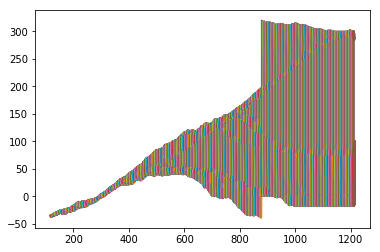

In [3]:
## grab some particles, randomly, again from Adele's output
filename = '/g/data/v45/akm157/runs/CMS_exps/saved_kelp_particle_data/SGeorgia_hycom_new_stokes/particles_for_Andy_hycom_Ant.nc'
particles = nc.Dataset(filename)
#lon1 = particles.variables['traj_lon'][[0,1,5,6,9,10,12],:] 
lon1 = particles.variables['traj_lon'][:,:] 
lon1[lon1<-40] = lon1[lon1<-40] + 360
#lat1 = particles.variables['traj_lat'][[0,1,5,6,9,10,12],:]
lat1 = particles.variables['traj_lat'][:,:]
time1 = particles.variables['particle_time'][:,:]
n_Ant = lat1.shape[0]

filename = '/g/data/v45/akm157/runs/CMS_exps/saved_kelp_particle_data/SGeorgia_hycom_new_stokes/particles_for_Andy_hycom_notAnt.nc'
particles = nc.Dataset(filename)
#lon2 = particles.variables['traj_lon'][[0,4,5,6,10,12,13],:] 
lon2 = particles.variables['traj_lon'][:100,:] 
lon2[lon2<-40] = lon2[lon2<-40] + 360
#lat2 = particles.variables['traj_lat'][[0,4,5,6,10,12,13],:]
lat2 = particles.variables['traj_lat'][:100,:]
time2 = particles.variables['particle_time'][:,:]
n_notAnt = lat2.shape[0]

# Note that these particles start at ~-35 and go around Antarctica to -40. 
# Shift grid to run from -40-320.

plt.plot(time1,lon1)

In [4]:
# function to do latitude shifting:
# To be consistent with particles, let's do -40 to 320
# HYCOM data goes from 74.16 to 434.08 (what a strange choice!!)
# Total longitude range is 4500 gridpoints
# This function works OK, but is very slow. Can I vectorise better?
def shifted(input,xu_ocean):
    ii = np.max(np.where(xu_ocean==320))
    if input.ndim == 1:
        nx = input.shape[0] + 500
        shifted = np.zeros(nx)
        shifted[(nx-ii):] = input[:ii]
        shifted[:(nx-ii)] = input[ii-500:]
    else:
        ny,nx = input.shape
        nx = nx+500
        shifted = np.zeros((ny,nx))
        shifted[:,(nx-ii):] = input[:,:ii]
        shifted[:,:(nx-ii)] = input[:,ii-500:]
    return shifted

In [5]:
# function to make boundary path
# make a path around boundary to create a sector map, then cut it out
def make_boundary_path(lons,lats):
    boundary_path = np.array([lons[-1,:],lats[-1,:]])
    boundary_path = np.append(boundary_path,np.array([lons[::-1,-1],lats[::-1,-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[1,::-1],lats[1,::-1]]),axis=1)
    boundary_path = np.append(boundary_path,np.array([lons[:,1],lats[:,1]]),axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

CPU times: user 849 ms, sys: 169 ms, total: 1.02 s
Wall time: 1.45 s


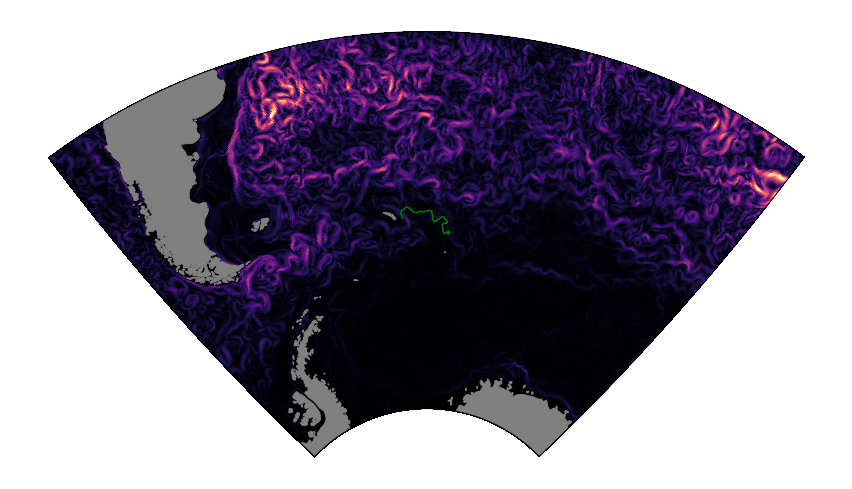

In [6]:
%%time

# to start with, let's just plot a frame
midlon = -30
maxlon = midlon + 50
minlon = midlon-50
minlat = -75
maxlat = -35
midlat = (minlat + maxlat)/2

fig = plt.figure(1,figsize=(12,6.5))
fig.patch.set_facecolor('white')
ax = plt.axes(projection=ccrs.Stereographic(central_longitude=midlon,central_latitude=midlat))
ax.coastlines(resolution='50m')

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='gray')
ax.add_feature(land_50m)
#ax.add_feature(cft.LAND)

data = xr.open_dataset(file)

## xarray can't really work on this hycom data, so we will cheat a bit
# First, set latitude range
yy = data.Latitude.isel(X=0).values
south_index = (np.abs(yy-minlat)).argmin() - 1

## Now shift grid and set longitude range.
xx = data.Longitude.isel(Y=0).values
xx_shift = shifted(xx,xx)
## OK, this bit is a real fudge ...
tmp = xx_shift[:2000]
tmp[tmp>=270] = tmp[tmp>=270]- 360
xx_shift[:2000]=tmp
west_index = (np.abs(xx_shift-minlon)).argmin() 
east_index = (np.abs(xx_shift-maxlon)).argmin() -1


#ssh = data.ssh.isel(MT=0).values
ssh = shifted(data.ssh.isel(MT=0).values,xx)[south_index:,west_index:east_index]
#lons = data.Longitude.values
all_lons = shifted(data.Longitude.values,xx)
tmp = all_lons[:,:2000]
tmp[tmp>=270] = tmp[tmp>=270]- 360
all_lons[:,:2000]=tmp
lons = all_lons[south_index:,west_index:east_index]
#lats = data.Latitude.values

#ssh = data.ssh.isel(MT=0).isel(Y=slice(south_index,-1)).isel(X=slice(west_index,east_index)).values
#lons = data.Longitude.isel(Y=slice(south_index,-1)).isel(X=slice(west_index,east_index)).values
lats = data.Latitude.isel(Y=slice(south_index-1,-1)).isel(X=slice(west_index,east_index)).values

# calculate absolute velocity
# u = g/f*d(h)dy
u,v = np.gradient(ssh*9.81/110.0e3/1.e-4, 0.1, 0.1)*np.cos(lats*np.pi/180.0)
uv2 = ( u**2.0 + v**2.0 )**0.5
uv2 = np.nan_to_num(uv2)

# plot
plt.pcolormesh(lons, lats, uv2, cmap=plt.cm.magma, vmin=0, vmax=0.7, transform=ccrs.PlateCarree())
#plt.contourf(lons, lats, uv2, levels=np.linspace(0,0.7,20),cmap=plt.cm.magma, transform=ccrs.PlateCarree())

boundary_path = make_boundary_path(lons,lats)
ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
plt.subplots_adjust(left=0., right=1.0, top=1.0, bottom=0.0)

# Plot a particle path
plt.plot(lon1[0,1:50],lat1[0,1:50],'g-', transform=ccrs.PlateCarree())
plt.plot(lon1[0,50],lat1[0,50],'g.', transform=ccrs.PlateCarree())

#plt.savefig('frames/image0001.png',dpi=150)

In [ ]:
nframes = 1091
startframe = 121 # in days since Jan 1 2013 MUST BE MORE THAN 120!!
                 # Also, you can't have startframe + nt > 112
minlat = -75
maxlat = -35
midlat = (minlat + maxlat)/2
    
#def updatefig(nt):
for nt in range(476,nframes):    
    currentframe = startframe + nt
    year = 2013+np.floor((currentframe-1)/365)
    day = np.mod(currentframe-1,365)+1
    
    # Middle longitude for these particles.
    # bound by -40 and 320 for obvious reasons
    #midlon = np.min([np.max([np.mean(lon1[:,currentframe]),10]),260])
    midlon = np.min([(-30 + 290/830*np.max([currentframe-96-121,0])),260])
    minlon = midlon - 50 
    maxlon = midlon + 50
    #print(midlon,maxlon,minlon)
    print('On iteration:', currentframe, '- Map is centred on longitude: ',midlon)#, '- Particles are centred on:',lon1[0,currentframe],lat1[0,currentframe])
    
    iter = 'hycom_GLBa0.08_ssh_%4d_%03d.nc' % (year, day)
    print('Filename is '+iter)
    file = os.path.join(dir,iter)
    
    data = xr.open_dataset(file)

    ## xarray can't really work on this hycom data, so we will cheat a bit
    south_index = (np.abs(yy-minlat)).argmin() 
    west_index = (np.abs(xx_shift-minlon)).argmin() 
    east_index = (np.abs(xx_shift-maxlon)).argmin() -1
    #print(west_index,east_index)
    
    
    ssh = shifted(data.ssh.isel(MT=0).values,xx)[south_index:,west_index:east_index]
    #lons = shifted(data.Longitude.values,xx)  #[south_index:,west_index:east_index]
    # needs lons loaded from above
    lons = all_lons[south_index:,west_index:east_index]
    lats = shifted(data.Latitude.isel(Y=slice(south_index-1,-1)).values,xx)[:,west_index:east_index]

    # calculate absolute velocity:  u = g/f*d(h)dy
    u,v = np.gradient(ssh*9.81/110.0e3/1.e-4, 0.1, 0.1)*np.cos(lats*np.pi/180.0)
    uv2 = 2*( u**2.0 + v**2.0 )**0.5
    uv2 = np.nan_to_num(uv2)

    # plot
    fig = plt.figure(1,figsize=(12,6.8))
    fig.patch.set_facecolor('white')
    ax = plt.axes(projection=ccrs.Stereographic(central_longitude=midlon,central_latitude=midlat))
    ax.coastlines(resolution='50m')
    p1=ax.pcolormesh(lons, lats, uv2, cmap=plt.cm.magma, vmin=0, vmax=1.0, shading='gouraud',transform=ccrs.PlateCarree())
    
    # Now, add non-Antarctic particles
    for i in range(n_notAnt):
        head_index = np.where(time2[i,:]==currentframe)[0][0]
        tail_end_index = np.max([head_index-50,0])
        nsegments = head_index - tail_end_index
        xxx = lon2[i,tail_end_index:head_index]
        yyy = lat2[i,tail_end_index:head_index]    
        if not(np.ma.is_masked(xxx[-1])):
            if (minlon<xxx[-1])&(maxlon>xxx[-1])&(maxlat>yyy[-1]):
                if not((minlon<np.min(xxx))&(maxlon>np.max(xxx))&(maxlat>np.max(yyy))):
                    xxx=np.ma.masked_where(minlon>xxx,xxx)
                    xxx=np.ma.masked_where(maxlon<xxx,xxx)
                    yyy=np.ma.masked_where(maxlat<yyy,yyy)
                points = np.ma.array([xxx, yyy]).T.reshape(-1, 1, 2)
                segments = np.ma.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, color='deepskyblue') 
                lc.set_linewidth(np.arange(nsegments)/32)
                lca = ax.add_collection(lc)
                lca.set_transform(ccrs.PlateCarree())
                plt.plot(xxx[-1],yyy[-1],'.',color='deepskyblue',markersize=6,transform=ccrs.PlateCarree())
    
    
    # First, add Antarctic particles
    for i in range(n_Ant):
        head_index = np.where(time1[i,:]==currentframe)[0][0]
        tail_end_index = np.max([head_index-50,0])
        nsegments = head_index - tail_end_index
        xxx = lon1[i,tail_end_index:head_index]
        yyy = lat1[i,tail_end_index:head_index]    
        if not(np.ma.is_masked(xxx[-1])):
            if (minlon<xxx[-1])&(maxlon>xxx[-1])&(maxlat>yyy[-1]):
                if not((minlon<np.min(xxx))&(maxlon>np.max(xxx))&(maxlat>np.max(yyy))):
                    xxx=np.ma.masked_where(minlon>xxx,xxx)
                    xxx=np.ma.masked_where(maxlon<xxx,xxx)
                    yyy=np.ma.masked_where(maxlat<yyy,yyy)
                points = np.ma.array([xxx, yyy]).T.reshape(-1, 1, 2)
                segments = np.ma.concatenate([points[:-1], points[1:]], axis=1)
                lc = LineCollection(segments, color='orange') #,cmap=plt.get_cmap('copper'),norm=plt.Normalize(0, 40))
                lc.set_linewidth(np.arange(nsegments)/32)
                lca = ax.add_collection(lc)
                lca.set_transform(ccrs.PlateCarree())
                plt.plot(xxx[-1],yyy[-1],'.',color='orange',markersize=6,transform=ccrs.PlateCarree())
                
    boundary_path = make_boundary_path(lons,lats)
    ax.set_boundary(boundary_path, transform=ccrs.PlateCarree())
    #ax.add_feature(cft.LAND)
    ax.add_feature(land_50m)
    plt.subplots_adjust(left=0., right=1.0, top=1.0, bottom=0.0)
    data.close()
    
    
    ax3 = plt.axes([0.05,0.08,0.15,0.15*12/7],projection='polar')
    ax3.set_xticks([],[])
    ax3.set_yticks([],[])
    ax3.text(np.pi/2, 1.1, 'Summer',horizontalalignment='center',fontsize=12,fontweight='bold')
    ax3.text(3*np.pi/2, 1.1, 'Winter',verticalalignment='top',horizontalalignment='center',fontsize=12,fontweight='bold')
    ax3.text(0, 1.1, 'Autumn',verticalalignment='center',fontsize=12,rotation='-90',fontweight='bold')
    ax3.text(np.pi, 1.1, 'Spring',horizontalalignment='right',verticalalignment='center',fontsize=12,rotation='90',fontweight='bold')

    r = [0.2,0,1]
    theta = [-np.pi,0,np.pi]
    angle = (45-currentframe)*2*np.pi/365 + 0.5*np.pi
    ax3.arrow(angle,0,0,0.75, head_width=0.2, head_length=0.2,linewidth=3,fc='m')

    ax4 = plt.axes([0.88,0.1,0.01,0.35])
    cb = plt.colorbar(p1,cax=ax4,orientation='vertical',ticks=[0, 0.25, 0.5, 0.75, 1.0] )
    cb.ax.set_xlabel('Current\n Speed (m/s)',fontsize=12)

    
    filestr = '/g/data/v45/amh157/frames/image%04d.png' % nt
    plt.savefig(filestr,dpi=150)
    plt.clf()
    #return p1

#anim = animation.FuncAnimation(fig, updatefig, frames=nframes, interval=50, blit=False)
#anim

#metadata = dict(title='Southern Ocean Movie', artist='GFD ANU',comment='Animation made using matplotlib and ffmpeg')
#ffwriter = animation.FFMpegWriter(fps=25, codec='libx264', bitrate=4000, extra_args=['-pix_fmt','yuv420p'], metadata=metadata)
#anim.save('SouthernOceanMovie.m4v',writer=ffwriter)



On iteration: 597 - Map is centred on longitude:  102.771084337
Filename is hycom_GLBa0.08_ssh_2014_232.nc
On iteration: 598 - Map is centred on longitude:  103.120481928
Filename is hycom_GLBa0.08_ssh_2014_233.nc
On iteration: 599 - Map is centred on longitude:  103.469879518
Filename is hycom_GLBa0.08_ssh_2014_234.nc
On iteration: 600 - Map is centred on longitude:  103.819277108
Filename is hycom_GLBa0.08_ssh_2014_235.nc
On iteration: 601 - Map is centred on longitude:  104.168674699
Filename is hycom_GLBa0.08_ssh_2014_236.nc
On iteration: 602 - Map is centred on longitude:  104.518072289
Filename is hycom_GLBa0.08_ssh_2014_237.nc
On iteration: 603 - Map is centred on longitude:  104.86746988
Filename is hycom_GLBa0.08_ssh_2014_238.nc
On iteration: 604 - Map is centred on longitude:  105.21686747
Filename is hycom_GLBa0.08_ssh_2014_239.nc
On iteration: 605 - Map is centred on longitude:  105.56626506
Filename is hycom_GLBa0.08_ssh_2014_240.nc
On iteration: 606 - Map is centred on lo

On iteration: 674 - Map is centred on longitude:  129.674698795
Filename is hycom_GLBa0.08_ssh_2014_309.nc
On iteration: 675 - Map is centred on longitude:  130.024096386
Filename is hycom_GLBa0.08_ssh_2014_310.nc
On iteration: 676 - Map is centred on longitude:  130.373493976
Filename is hycom_GLBa0.08_ssh_2014_311.nc
On iteration: 677 - Map is centred on longitude:  130.722891566
Filename is hycom_GLBa0.08_ssh_2014_312.nc
On iteration: 678 - Map is centred on longitude:  131.072289157
Filename is hycom_GLBa0.08_ssh_2014_313.nc
On iteration: 679 - Map is centred on longitude:  131.421686747
Filename is hycom_GLBa0.08_ssh_2014_314.nc
On iteration: 680 - Map is centred on longitude:  131.771084337
Filename is hycom_GLBa0.08_ssh_2014_315.nc
On iteration: 681 - Map is centred on longitude:  132.120481928
Filename is hycom_GLBa0.08_ssh_2014_316.nc
On iteration: 682 - Map is centred on longitude:  132.469879518
Filename is hycom_GLBa0.08_ssh_2014_317.nc
On iteration: 683 - Map is centred on

On iteration: 751 - Map is centred on longitude:  156.578313253
Filename is hycom_GLBa0.08_ssh_2015_021.nc
On iteration: 752 - Map is centred on longitude:  156.927710843
Filename is hycom_GLBa0.08_ssh_2015_022.nc
On iteration: 753 - Map is centred on longitude:  157.277108434
Filename is hycom_GLBa0.08_ssh_2015_023.nc
On iteration: 754 - Map is centred on longitude:  157.626506024
Filename is hycom_GLBa0.08_ssh_2015_024.nc
On iteration: 755 - Map is centred on longitude:  157.975903614
Filename is hycom_GLBa0.08_ssh_2015_025.nc
On iteration: 756 - Map is centred on longitude:  158.325301205
Filename is hycom_GLBa0.08_ssh_2015_026.nc
On iteration: 757 - Map is centred on longitude:  158.674698795
Filename is hycom_GLBa0.08_ssh_2015_027.nc
On iteration: 758 - Map is centred on longitude:  159.024096386
Filename is hycom_GLBa0.08_ssh_2015_028.nc
On iteration: 759 - Map is centred on longitude:  159.373493976
Filename is hycom_GLBa0.08_ssh_2015_029.nc
On iteration: 760 - Map is centred on

On iteration: 828 - Map is centred on longitude:  183.481927711
Filename is hycom_GLBa0.08_ssh_2015_098.nc
On iteration: 829 - Map is centred on longitude:  183.831325301
Filename is hycom_GLBa0.08_ssh_2015_099.nc
On iteration: 830 - Map is centred on longitude:  184.180722892
Filename is hycom_GLBa0.08_ssh_2015_100.nc
On iteration: 831 - Map is centred on longitude:  184.530120482
Filename is hycom_GLBa0.08_ssh_2015_101.nc
On iteration: 832 - Map is centred on longitude:  184.879518072
Filename is hycom_GLBa0.08_ssh_2015_102.nc
On iteration: 833 - Map is centred on longitude:  185.228915663
Filename is hycom_GLBa0.08_ssh_2015_103.nc
On iteration: 834 - Map is centred on longitude:  185.578313253
Filename is hycom_GLBa0.08_ssh_2015_104.nc
On iteration: 835 - Map is centred on longitude:  185.927710843
Filename is hycom_GLBa0.08_ssh_2015_105.nc
On iteration: 836 - Map is centred on longitude:  186.277108434
Filename is hycom_GLBa0.08_ssh_2015_106.nc
On iteration: 837 - Map is centred on

On iteration: 905 - Map is centred on longitude:  210.385542169
Filename is hycom_GLBa0.08_ssh_2015_175.nc
On iteration: 906 - Map is centred on longitude:  210.734939759
Filename is hycom_GLBa0.08_ssh_2015_176.nc
On iteration: 907 - Map is centred on longitude:  211.084337349
Filename is hycom_GLBa0.08_ssh_2015_177.nc
On iteration: 908 - Map is centred on longitude:  211.43373494
Filename is hycom_GLBa0.08_ssh_2015_178.nc
On iteration: 909 - Map is centred on longitude:  211.78313253
Filename is hycom_GLBa0.08_ssh_2015_179.nc
On iteration: 910 - Map is centred on longitude:  212.13253012
Filename is hycom_GLBa0.08_ssh_2015_180.nc
On iteration: 911 - Map is centred on longitude:  212.481927711
Filename is hycom_GLBa0.08_ssh_2015_181.nc
On iteration: 912 - Map is centred on longitude:  212.831325301
Filename is hycom_GLBa0.08_ssh_2015_182.nc
On iteration: 913 - Map is centred on longitude:  213.180722892
Filename is hycom_GLBa0.08_ssh_2015_183.nc
On iteration: 914 - Map is centred on lo

On iteration: 982 - Map is centred on longitude:  237.289156627
Filename is hycom_GLBa0.08_ssh_2015_252.nc
On iteration: 983 - Map is centred on longitude:  237.638554217
Filename is hycom_GLBa0.08_ssh_2015_253.nc
On iteration: 984 - Map is centred on longitude:  237.987951807
Filename is hycom_GLBa0.08_ssh_2015_254.nc
On iteration: 985 - Map is centred on longitude:  238.337349398
Filename is hycom_GLBa0.08_ssh_2015_255.nc
On iteration: 986 - Map is centred on longitude:  238.686746988
Filename is hycom_GLBa0.08_ssh_2015_256.nc
On iteration: 987 - Map is centred on longitude:  239.036144578
Filename is hycom_GLBa0.08_ssh_2015_257.nc
On iteration: 988 - Map is centred on longitude:  239.385542169
Filename is hycom_GLBa0.08_ssh_2015_258.nc
On iteration: 989 - Map is centred on longitude:  239.734939759
Filename is hycom_GLBa0.08_ssh_2015_259.nc
On iteration: 990 - Map is centred on longitude:  240.084337349
Filename is hycom_GLBa0.08_ssh_2015_260.nc
On iteration: 991 - Map is centred on

On iteration: 1059 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_329.nc
On iteration: 1060 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_330.nc
On iteration: 1061 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_331.nc
On iteration: 1062 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_332.nc
On iteration: 1063 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_333.nc
On iteration: 1064 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_334.nc
On iteration: 1065 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_335.nc
On iteration: 1066 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_336.nc
On iteration: 1067 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_337.nc
On iteration: 1068 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2015_338.nc


On iteration: 1141 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_046.nc
On iteration: 1142 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_047.nc
On iteration: 1143 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_048.nc
On iteration: 1144 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_049.nc
On iteration: 1145 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_050.nc
On iteration: 1146 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_051.nc
On iteration: 1147 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_052.nc
On iteration: 1148 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_053.nc
On iteration: 1149 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_054.nc
On iteration: 1150 - Map is centred on longitude:  260.0
Filename is hycom_GLBa0.08_ssh_2016_055.nc


In [ ]:
# still to do here:

#NOTES
# Longitude in HYCOM data goes from 74°E to 434°E
# Longitude in particle tracks from 80 to 440, once I add 360 to it.
# To wrap, I have just applied shiftgrid to cover the whole sector

In [2]:
# Code to make the movie from the frames
!ffmpeg -framerate 20 -pattern_type glob -i '/g/data/v45/amh157/frames/image*.png' -s 1800x1020 -c:v libx264 -pix_fmt yuv420p KelpInTheSouthernOcean.mp4

ffmpeg version 3.4.2 Copyright (c) 2000-2018 the FFmpeg developers
  built with gcc 4.8.2 (GCC) 20140120 (Red Hat 4.8.2-15)
  configuration: --prefix=/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01 --disable-doc --enable-shared --enable-static --extra-cflags='-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC -I/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/include' --extra-cxxflags='=-Wall -g -m64 -pipe -O3 -march=x86-64 -fPIC' --extra-libs='-L/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.01/lib -lz' --enable-pic --enable-gpl --enable-version3 --enable-hardcoded-tables --enable-avresample --enable-libfreetype --enable-gnutls --enable-libx264
  libavutil      55. 78.100 / 55. 78.100
  libavcodec     57.107.100 / 57.107.100
  libavformat    57. 83.100 / 57. 83.100
  libavdevice    57. 10.100 / 57. 10.100
  libavfilter     6.107.100 /  6.107.100
  libavresample   3.  7.  0 /  3.  7.  0
  libswscale      4.  8.100 /  4.  8.100
  libswresample   2.  9.100 /  2.  9.100
 